# Two-point statistics from *Heracles*

This notebook demonstrates how *Heracles* extracts the two-point statistics from a *LE3-WL* shear catalogue.

The statistics are done here at a much lower resolution than for the scientific goals of *Euclid*. That is because at the target resolution of *NSIDE = 4K* for the position and shear maps (1.5G per map) and *NSIDE = 8K* for the visibility and weight maps (6G per map), the memory required makes it impossible to hold all maps at once. In an actual pipeline, each map is constructed in isolation by a separate worker instance, and each worker only holds the data it requires at each step.

The example uses the [*Flagship2* data for *LE3-WL*](https://sdcuk-webdav.roe.ac.uk/LE3_WL_Flagship2/). The catalogue contains about 128 million galaxies, roughly corresponding to *Euclid* DR1 in the north.

<div class="alert alert-block alert-warning">
    <p><strong>Note:</strong> This notebook is meant to give you an idea of <strong>how <em>Heracles</em> works</strong>.</p>
    <p><ul>
        <li>The notebook does <strong>not</strong> perform a very thorough analysis.</li>
        <li>The notebook does <strong>not</strong> show everything that <em>Heracles</em> can do.</li>
        <li>The notebook does <strong>not</strong> indicate how good the eventual <em>Euclid</em> results may or may not be.</li>
        <li>The notebook does <strong>not</strong> treat all observational effects we know about.</li>
        <li>The notebook does <strong>not</strong> model the expected signal properly.</li>
    </ul></p>
    <p><strong>This is a toy, treat it is such!</strong></p>
</div>

**Contents:**

* [Setup](#Setup)
* [Basic parameters](#Basic-parameters)
* [Catalogues](#Catalogues)
* [Tomographic binning](#Tomographic-binning)
* [Visibility maps](#Visibility-maps)
* [Maps](#Maps)
* [Alms](#Alms)
* [Two-point statistics](#Two-point-statistics)
* [Noise bias](#Noise-bias)
* [Debiasing](#Debiasing)
* [Mixing matrices](#Mixing-matrices)
* [Theory](#Theory)
* [Results](#Results)

## Setup

Uncomment this to enable info-level logging. This produces quite a lot of output below, but will show exactly what is going on while you are waiting for results.

In [1]:
#import logging
#logging.basicConfig(level=logging.INFO)

Some required imports, nothing fancy.

In [2]:
import numpy as np
import healpy as hp
import fitsio
import matplotlib.pyplot as plt
import matplotlib as mpl

## Basic parameters

As initially mentioned, set this to values such that your machine does not blow up when this example keeps all maps in memory at the same time.

In [3]:
nside = 1024
lmax = 1000

## Catalogues

*Heracles* provides a flexible interface for loading catalogues from FITS files or arrays. It also provides a base that can quickly be extended e.g. to databases or more.

Here we use the FITS interface to read a catalogue from file. We could specify the columns to read, but we don't do that here, because the catalogue only has columns of interest here.

Catalogues are never read into memory all at once. The `page_size` property determines how many rows are read at a time.

In [4]:
from heracles.catalog import FitsCatalog

In [5]:
# load the FITS catalogue
wlfs2_cat = FitsCatalog('/pscratch/sd/j/jaimerz/Data/reduced_flagship2/wlfs2_dr1n_vis24.5_nomag.fits')

In [6]:
wlfs2_cat

/pscratch/sd/j/jaimerz/Data/reduced_flagship2/wlfs2_dr1n_vis24.5_nomag.fits

Using the `.add_filter()` method, we could add filters to the catalogue here which e.g. strip rows with invalid values, or apply an extra footprint mask to the catalogue.

### Playground

The `Catalog` interface is essentially an interator over pages of catalogue data. You can use it as such:

In [7]:
nrows = 0
for page in wlfs2_cat:
    nrows += page.size

# no need to iterate to get the number of rows, really
assert nrows == wlfs2_cat.size

print(f'there are {nrows:_} rows in your catalogue')

there are 128_179_253 rows in your catalogue


The `page` object is a mapping of column names to rows, with some additional features:

* The number of rows, `page.size`
* The names of columns, `page.names`
* A view of the underlying data, `page.data`
* Make a copy of the page, `page.copy()`
* Delete specific rows, `page.delete(where)`
* Return multiple columns at once, using `page['a', 'b']` or `page[['a', 'b']]`
* Return columns while checking for invalid values using `page.get('a', 'b')`

## Visibility maps

The position statistics require knowledge of the *a priori* probability of detecting a galaxy at each point in the sky. We call this the *visibility*, and we use it in the form of *visibility maps*, which are full-sky maps of detection probabilities.

In [8]:
vmap = hp.read_map('/pscratch/sd/j/jaimerz/Data/reduced_flagship2/vmap_wlfs2_dr1n_vis24.5_mag.fits')

# fix UNSEEN pixels to zero and rescale to nside
vmap[vmap == hp.UNSEEN] = 0.
vmap = hp.ud_grade(vmap, 2*nside)

For a real survey, the visibility is a complicated function of position, observing conditions, and selection. Each tomographic bin would thus normally require an individual visibility map. However, in this simulated example, the selection is the same for all positions and tomographic bins, and the visibility map is simply the footprint map of the survey.

In [9]:
# set visibility map of entire catalogue
wlfs2_cat.visibility = vmap

### Playground

Quick inspection of the visibility map:

0.0 180.0 -180.0 180.0


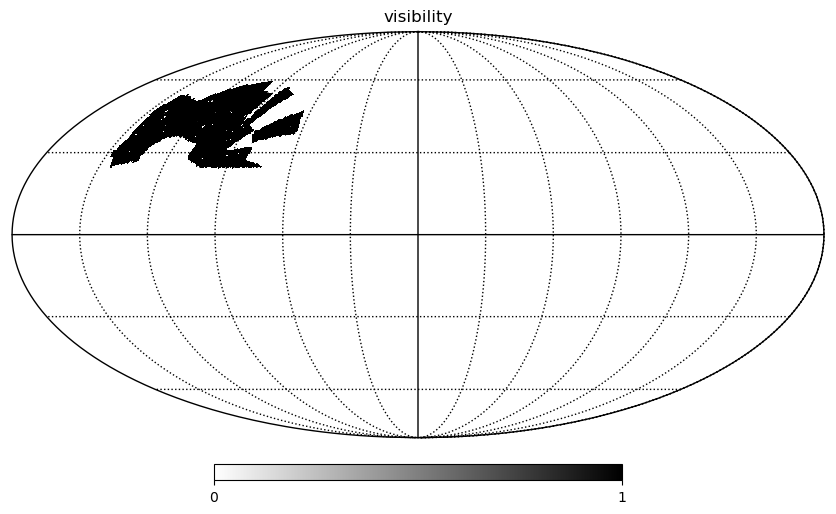

In [10]:
hp.mollview(vmap, title='visibility', cmap='binary', bgcolor='none')
hp.graticule()
plt.show()

## Tomographic binning

The `wlfs2_cat` object can be used to read the entire catalogue. However, we would like to split our galaxies into individual tomographic bins. In fact, each galaxy has already been assigned a label that says which tomographic bin it belongs to, in the `TOM_BIN_ID` column.

To perform the tomographic binning, we construct a `dict` that assigns a bin ID of type `int` to a catalogue. We perform a selection on the `wlfs2_cat` FITS using the `[]` syntax, which returns a new view of the `FitsCatalog` with the given row filter applied.

In [11]:
catalogs = {i: wlfs2_cat[f'TOM_BIN_ID == {i}'] for i in range(10)}

In [12]:
catalogs

{0: /pscratch/sd/j/jaimerz/Data/reduced_flagship2/wlfs2_dr1n_vis24.5_nomag.fits['TOM_BIN_ID == 0'],
 1: /pscratch/sd/j/jaimerz/Data/reduced_flagship2/wlfs2_dr1n_vis24.5_nomag.fits['TOM_BIN_ID == 1'],
 2: /pscratch/sd/j/jaimerz/Data/reduced_flagship2/wlfs2_dr1n_vis24.5_nomag.fits['TOM_BIN_ID == 2'],
 3: /pscratch/sd/j/jaimerz/Data/reduced_flagship2/wlfs2_dr1n_vis24.5_nomag.fits['TOM_BIN_ID == 3'],
 4: /pscratch/sd/j/jaimerz/Data/reduced_flagship2/wlfs2_dr1n_vis24.5_nomag.fits['TOM_BIN_ID == 4'],
 5: /pscratch/sd/j/jaimerz/Data/reduced_flagship2/wlfs2_dr1n_vis24.5_nomag.fits['TOM_BIN_ID == 5'],
 6: /pscratch/sd/j/jaimerz/Data/reduced_flagship2/wlfs2_dr1n_vis24.5_nomag.fits['TOM_BIN_ID == 6'],
 7: /pscratch/sd/j/jaimerz/Data/reduced_flagship2/wlfs2_dr1n_vis24.5_nomag.fits['TOM_BIN_ID == 7'],
 8: /pscratch/sd/j/jaimerz/Data/reduced_flagship2/wlfs2_dr1n_vis24.5_nomag.fits['TOM_BIN_ID == 8'],
 9: /pscratch/sd/j/jaimerz/Data/reduced_flagship2/wlfs2_dr1n_vis24.5_nomag.fits['TOM_BIN_ID == 9']}

View have their own invididual `.visibility` property, but inherit the visibility of the base catalogue by default.

Instead of the `[]` syntax, view can also be created using the `.where()` method, in which case the visibility can be given directly.

In [13]:
catalogs[3].visibility is vmap

True

Note that `catalogs` is a simple mapping of integer bin IDs to instances of type `Catalog`. You can create such a mapping in any way you like; the values do not have to come from the same `FitsCatalog`, or even the same type of catalogue.

### Playground

Return the number of rows in tomographic bin 5.

In [14]:
# need to sum because FITS cannot tell the size a priori
nrows = sum(page.size for page in catalogs[5])

print(f'tomographic bin 5 contains {nrows:_} rows')

tomographic bin 5 contains 12_327_094 rows


## Fields

In [15]:
from heracles.fields import Positions, Shears
from heracles.maps import Healpix

To make maps, *Heracles* requires a so-called mapper object, which knows how to map positions and values onto e.g. HEALPix pixels. Here, we construct a `Healpix` mapper instance with our desired *NSIDE* and *LMAX* parameters. When transforming the maps, the HEALPix mapper will also remove the pixel window function, unless `deconvolve=False` is passed.

In [16]:
mapper = Healpix(nside, lmax)

To specify the fields we wish to analyse, we construct a dictionary of keys and field definitions. Each of these receives a mapper and a list of columns that it reads, plus potentially some other options.

For a standard 3x2pt analysis in harmonic space, we need

* A position field (`"P"`) for angular clustering and galaxy-galaxy lensing;
* A shear field (`"G"`) for cosmic shear and galaxy-galaxy lensing.

We also specify that the shear field should flip the sign of the "G2" column by adding a minus sign.

Finally, we define the optional names of the masks (`"V"`, `"W"`) of the fields. These will be used further down below to compute mixing matrices.

In [17]:
fields = {
    "P": Positions(mapper, "RIGHT_ASCENSION", "DECLINATION", mask="V"),
    "G": Shears(mapper, "RIGHT_ASCENSION", "DECLINATION", "G1", "-G2", "WEIGHT", mask="W"),
}

## Maps

In [18]:
from heracles.maps import map_catalogs

The next step is to produce maps of our position and shear fields from the catalogues for each tomographic bin.

Now we are able to create maps of the tomographic catalogues. *Heracles* can map a whole set of catalogues all at once, using the `map_catalogs()` functions. We only need to pass in the desired mapper, as well as the fields and catalogues constructed previously.

In [19]:
maps = map_catalogs(fields, catalogs, parallel=True, progress=True)

/global/homes/j/jaimerz/.conda/envs/gitd/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/global/homes/j/jaimerz/.conda/envs/gitd/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/global/homes/j/jaimerz/.conda/envs/gitd/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/global/homes/j/jaimerz/.conda/envs/gitd/lib/python3.10/site-packages/heracles/fields.py:268: UserWarning: position
and visibility maps have different NSIDE
  warnings.warn("position and visibility maps have different NSIDE")

The resulting `maps` dictionary has keys consisting of a field key (`"P"`, `"G"`) and a catalogue key (`0`, `1`, ...). Results from *Heracles* are always of this form, which we call "toc dicts", short for "table of contents dictionaries" from how the data was originally written to disk.

In [20]:
list(maps.keys())[:8] + ['...']

[('P', 0),
 ('G', 0),
 ('P', 1),
 ('G', 1),
 ('P', 2),
 ('G', 2),
 ('P', 3),
 ('G', 3),
 '...']

In [21]:
maps[('P', 0)]

array([0., 0., 0., ..., 0., 0., 0.])

### Playground

We can take a quick look at the maps for a tomographic bin ID, say 3.

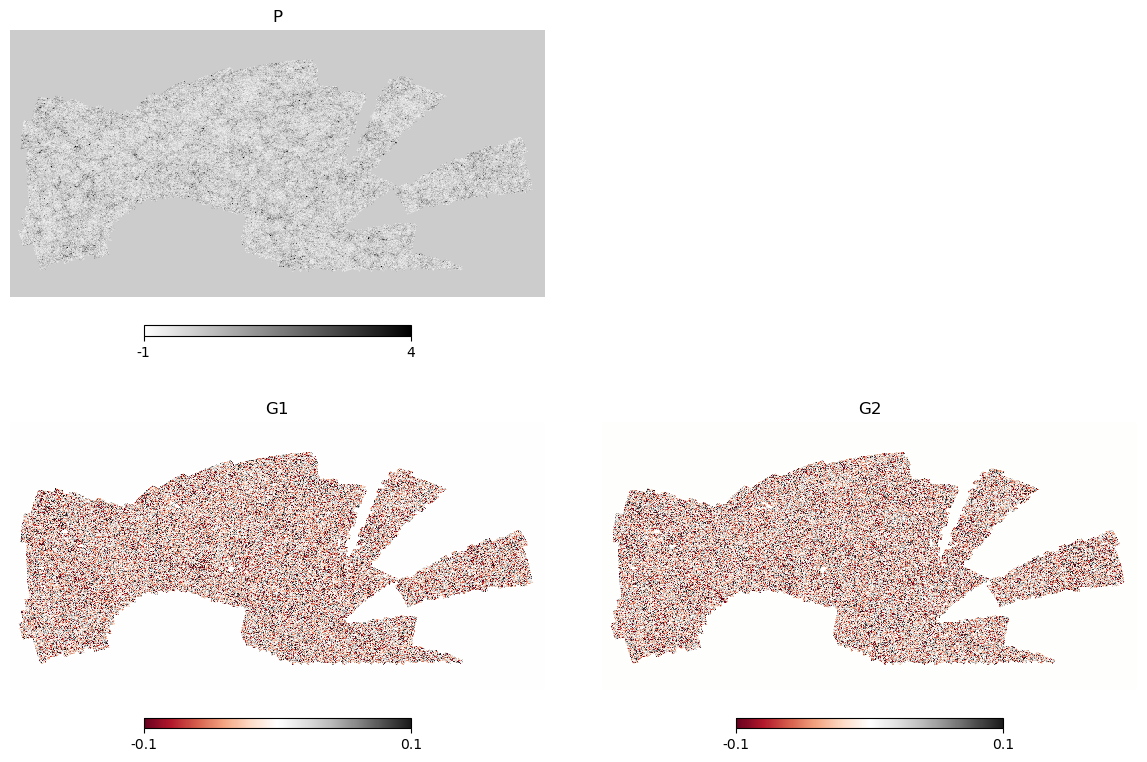

In [22]:
i = 3

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout()
plt.sca(ax[0, 0])
hp.cartview(maps['P', i], title='P', cmap='binary', min=-1., max=4., hold=True,
            lonra=[60, 150], latra=[20, 65])
ax[0, 1].axis('off')
plt.sca(ax[1, 0])
hp.cartview(maps['G', i][0], title='G1', cmap='RdGy', min=-0.1, max=0.1, hold=True,
            lonra=[60, 150], latra=[20, 65])
plt.sca(ax[1, 1])
hp.cartview(maps['G', i][1], title='G2', cmap='RdGy', min=-0.1, max=0.1, hold=True,
            lonra=[60, 150], latra=[20, 65])
plt.show()

## Alms

In [23]:
from heracles.maps import transform_maps

Since we are working in harmonic space, the real-space maps we created so far are not what we are actually after. We therefore transform them into harmonic-space maps (i.e. $a_{lm}$) using the `transform_maps()` function.

In [24]:
alms = transform_maps(fields, maps, progress=True)

The resulting `alm` object is another toc dict with keys for map ID (`P`, `G_E`, `G_B`) and bin ID.

In [25]:
list(alms.keys())[:9] + ['...']

[('P', 0),
 ('G_E', 0),
 ('G_B', 0),
 ('P', 1),
 ('G_E', 1),
 ('G_B', 1),
 ('P', 2),
 ('G_E', 2),
 ('G_B', 2),
 '...']

## Two-point statistics

In [26]:
from heracles.twopoint import angular_power_spectra

We are now able to compute the two-point statistics in the form of angular power spectra. We simply call the `angular_power_spectra()` function on the `alms`. The function will also remove the noise bias from the spectra (unless `debias=False` is passed), and can optionally compute binned spectra (using the `bins=` and `weights=` parameters).

In [27]:
cls = angular_power_spectra(alms)

We could limit the `cls` we want computed using the `include=` and `exclude=` parameters to `angular_power_specta()`, but here we have computed all combinations. They are very many, arranged in a toc dict with entries such as `('P', 'G_E', 5, 4)` for the position and *E*-mode angular power spectrum between bin IDs 5 and 4 (in order).

In [28]:
list(cls.keys())[:6] + ['...'] + list(cls.keys())[-6:]

[('P', 'P', 0, 0),
 ('P', 'G_E', 0, 0),
 ('P', 'G_B', 0, 0),
 ('P', 'P', 0, 1),
 ('P', 'G_E', 0, 1),
 ('P', 'G_B', 0, 1),
 '...',
 ('P', 'P', 9, 9),
 ('P', 'G_E', 9, 9),
 ('P', 'G_B', 9, 9),
 ('G_E', 'G_E', 9, 9),
 ('G_E', 'G_B', 9, 9),
 ('G_B', 'G_B', 9, 9)]

## Mixing matrices

In [29]:
from heracles.fields import Visibility, Weights
from heracles.twopoint import mixing_matrices

The second observational effect is that we do not have data over the entire sky, but are limited by the survey footprint and visibility. This effect is modelled at the level of two-point statistics by the so-called mixing matrices.

Computing the mixing matrices requires separate maps for the visibility and shear weights in each tomographic bin. The mixing matrices for angular power spectra up to `lmax` require `2*lmax` angular modes themselves, so we double the resolution.

In [30]:
mapper_mm = Healpix(2*nside, 2*lmax)

We now use the same catalogues to create the visibility and weight maps, using the `map_catalogs()` function as before. Of course, we could have also computed all maps in one go.

In [31]:
# visibility maps are taken as-is from catalogue, so no columns
fields_mm = {
    "V": Visibility(mapper_mm),
    "W": Weights(mapper_mm, "RIGHT_ASCENSION", "DECLINATION", "WEIGHT"),
}

maps_mm = map_catalogs(fields_mm, catalogs, parallel=True, progress=True)

/global/homes/j/jaimerz/.conda/envs/gitd/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [32]:
maps_mm[('V', 0)]

array([0., 0., 0., ..., 0., 0., 0.])

The output has the same format as earlier, but now contains `V` and `W` maps as expected.

In [33]:
list(maps_mm.keys())[:15]

[('V', 0),
 ('W', 0),
 ('V', 1),
 ('W', 1),
 ('V', 2),
 ('W', 2),
 ('V', 3),
 ('W', 3),
 ('V', 4),
 ('W', 4),
 ('V', 5),
 ('W', 5),
 ('V', 6),
 ('W', 6),
 ('V', 7)]

Next we transform the maps for the mixing matrices ...

In [34]:
alms_mm = transform_maps(fields_mm, maps_mm, progress=True)

... and compute their angular power spectra.

In [35]:
cls_mm = angular_power_spectra(alms_mm)

With the angular power spectra of visibility and weight maps available, we can compute all mixing matrices with the `mixing_matrices()` function. The function can optionally compute mixing matrices for binned spectra using the `bins=` and `weights=` parameters.

In [36]:
mms = mixing_matrices(fields, cls_mm, l1max=lmax, l2max=lmax, progress=True)

The mixing matrices are returned in a toc dict with familiar names: They correspond to the _output_ angular power spectra after mixing by a given matrix:

* `P, P` for `(P, P) → (P, P)`;
* `P, G_E` for `(P, G_E) → (P, G_E)`, as well as `(P, G_B) → (P, G_B)`;
* `G_E, G_E` for `(G_E, G_E) → (G_E, G_E)`, as well as `(G_B, G_B) → (G_B, G_B)`;
* `G_B, G_B` for `(G_E, G_E) → (G_B, G_B)`, as well as `(G_B, G_B) → (G_E, G_E)`;
* `G_E, G_B` for `(G_E, G_B) → (G_E, G_B)`.

For more details, see e.g. the paper by Brown, Castro & Taylor (2005).

In [37]:
list(mms.keys())[:6] + ['...'] + list(mms.keys())[-6:]

[('P', 'P', 0, 0),
 ('P', 'G_E', 0, 0),
 ('P', 'P', 0, 1),
 ('P', 'G_E', 0, 1),
 ('P', 'P', 0, 2),
 ('P', 'G_E', 0, 2),
 '...',
 ('G_E', 'G_B', 8, 9),
 ('P', 'P', 9, 9),
 ('P', 'G_E', 9, 9),
 ('G_E', 'G_E', 9, 9),
 ('G_B', 'G_B', 9, 9),
 ('G_E', 'G_B', 9, 9)]

In [39]:
np.shape(cls[('P', 'P', 0, 0)])

(1001,)

In [40]:
np.shape(mms[('P', 'P', 0, 0)])

(1001, 1001)

Now we want to try to deconvolve the measured cls with the mixing matrix. 

In [38]:
from heracles.core import TocDict

deconvolved_cls = TocDict()
for i, s1 in enumerate(sources):
    for j, s2 in enumerate(sources[i:]):
        i1, i2 = i//2, (i+j)//2

        cl = cls[f'W{i+1}xW{i+j+1}']

        if s1.source_type == 'counts' and s2.source_type == 'counts':
            deconvolved_cls['P', 'P', i1, i2] = mms['P', 'P', i1, i2] @ cl
        elif s1.source_type == 'lensing' and s2.source_type == 'lensing':
            deconvolved_cls['G_E', 'G_E', i1, i2] = mms['G_E', 'G_E', i1, i2] @ (cl*fl**2)
            deconvolved_cls['G_B', 'G_B', i1, i2] = mms['G_B', 'G_B', i1, i2] @ (cl*fl**2)
        elif s1.source_type == 'counts' and s2.source_type == 'lensing':
            deconvolved_cls['P', 'G_E', i1, i2] = mms['P', 'G_E', i1, i2] @ (cl*fl)
            deconvolved_cls['P', 'G_B', i1, i2] = np.zeros_like(cl)
        elif s1.source_type == 'lensing' and s2.source_type == 'counts':
            deconvolved_cls['P', 'G_E', i2, i1] = mms['P', 'G_E', i2, i1] @ (cl*fl)
            deconvolved_cls['P', 'G_B', i2, i1] = np.zeros_like(cl)

NameError: name 'sources' is not defined

### Playground

Have a look at the visibility and weight map for a bin ID, say 7.

In [ ]:
i = 7

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
fig.tight_layout()
plt.sca(ax[0])
hp.cartview(maps_mm['V', i], title='V', cmap='binary', hold=True,
            lonra=[60, 150], latra=[20, 65])
plt.sca(ax[1])
hp.cartview(maps_mm['W', i], title='W', cmap='binary', hold=True,
            lonra=[60, 150], latra=[20, 65])
plt.show()

Let's also look at one of the resulting mixing matrices, say the `++` one.

In [ ]:
plt.imshow(mms['G_E', 'G_E', i, i], cmap='binary',
            norm=mpl.colors.LogNorm(vmin=1e-7))
plt.colorbar(pad=0.025, fraction=0.0465)
plt.show()

## Theory

The final piece of the puzzle is a set of theory angular power spectra that model the full sky signal. Here we use *CAMB* to get a quick and dirty approximation of what the proper theory spectra might look like.

In [ ]:
import camb
from camb.sources import SplinedSourceWindow

We set the *CAMB* cosmology to match the *Flagship2* simulation, which is

* $\Omega_m = 0.319$,
* $\Omega_b = 0.049$,
* $\Omega_\Lambda + \Omega_\gamma = 0.681$,
* $A_s = 2.1 \cdot 10^{-9}$,
* $n_s = 0.96$,
* $h = 0.67$.

Also set some other properties that come straight from the *CAMBdemo* notebook.

In [ ]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67., omch2=0.270*0.67**2, ombh2=0.049*0.67**2)
pars.InitPower.set_params(As=2.1e-9, ns=0.96)
pars.Want_CMB = False 
pars.NonLinear = camb.model.NonLinear_both
pars.set_for_lmax(lmax, lens_potential_accuracy=1)

We need the redshift distributions for the tomographic bins. For the real data, these will be provided by *OU-PHZ* in some *TBD* format. Here, we use the file from the *Flagship2* catalogue for *LE3-WL* without asking any further questions.

In [ ]:
nz = fitsio.read('/pscratch/sd/j/jaimerz/Data/reduced_flagship2/nz_wlfs2_dr1n_vis24.5_mag.fits')

To compute the theory spectra of the galaxy number counts, we need the bias factor between matter and galaxies. This is a bias factor fitted to *Flagship2*, kindly provided by Isaac Tutusaus.

In [ ]:
z = nz['Z_MID']
bz = 0.83070341 + 1.19054721*z - 0.92835749*z**2 + 0.42329232*z**3

Given redshift distributions and bias factor, we can construct the *CAMB* source distributions for positions (counts) and shears (lensing).

In [ ]:
sources = []
for i in range(len(catalogs)):
    nz_i = nz[f'BIN{i}']
    sources += [
        SplinedSourceWindow(source_type='counts', z=z, W=nz_i, bias_z=bz),
        SplinedSourceWindow(source_type='lensing', z=z, W=nz_i),
    ]
pars.SourceWindows = sources

Use the `pars` we constructed above to compute the full sky theory spectra up to `lmax`, setting `raw_cl=True` to return unscaled $C_l$ values.

In [ ]:
results = camb.get_results(pars)
camb_cls = results.get_source_cls_dict(lmax=lmax, raw_cl=True)

This is the factor that's needed to convert from convergence to shear $C_l$.

In [ ]:
l = np.arange(lmax+1)
fl = -np.sqrt((l+2)*(l+1)*l*(l-1))
fl /= np.clip(l*(l+1), 1, None)

Now we can compute the theory spectra for our observations, using the *CAMB* results and the mixing matrices we computed earlier. We store everything in a toc dict using the same format as before.

In [ ]:
from heracles.core import TocDict

theory_cls = TocDict()
for i, s1 in enumerate(sources):
    for j, s2 in enumerate(sources[i:]):
        i1, i2 = i//2, (i+j)//2

        cl = camb_cls[f'W{i+1}xW{i+j+1}']

        if s1.source_type == 'counts' and s2.source_type == 'counts':
            theory_cls['P', 'P', i1, i2] = mms['P', 'P', i1, i2] @ cl
        elif s1.source_type == 'lensing' and s2.source_type == 'lensing':
            theory_cls['G_E', 'G_E', i1, i2] = mms['G_E', 'G_E', i1, i2] @ (cl*fl**2)
            theory_cls['G_B', 'G_B', i1, i2] = mms['G_B', 'G_B', i1, i2] @ (cl*fl**2)
        elif s1.source_type == 'counts' and s2.source_type == 'lensing':
            theory_cls['P', 'G_E', i1, i2] = mms['P', 'G_E', i1, i2] @ (cl*fl)
            theory_cls['P', 'G_B', i1, i2] = np.zeros_like(cl)
        elif s1.source_type == 'lensing' and s2.source_type == 'counts':
            theory_cls['P', 'G_E', i2, i1] = mms['P', 'G_E', i2, i1] @ (cl*fl)
            theory_cls['P', 'G_B', i2, i1] = np.zeros_like(cl)

## Results

Without much further ado, let's plot the results for positions and shears.  Fortunately, *Heracles* has plot routines which make this very easy.

In [ ]:
from heracles.plot import postage_stamps

In [ ]:
postage_stamps(
    [
        cls["G_E", "G_E"] | cls["G_B", "G_B"],
        theory_cls["G_E", "G_E"] | theory_cls["G_B", "G_B"],
    ],
    [
        cls["P", "P"],
        theory_cls["P", "P"],
    ],
    tryshift=2,
)
plt.show()

In [ ]:
postage_stamps(
    [
        cls["P", "G_E"] | cls["P", "G_B"],
        theory_cls["P", "G_E"] | theory_cls["P", "G_B"],
    ],
)
plt.show()

While agreement is not perfect, it's good enough, given how haphazardly we have performed the analysis and modelling of the expectation. We can certainly do better: For example, the missing power in the clustering signal at the lower end is likely due to the finite box size of the simulation, and associated lack of large-scale density perturbations (hat tip to Alex Hall for pointing this out). And there are intrinsic alignments in the simulation, but not in the theory. All of this and more must be modelled properly in a serious analysis.